## ***2023 Brain Age Predition - iFLYTEK A.I. Developer Competition***

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import torch

import missingno as msno

#### ***1 Load Dataset***

***This Dataset contains 12 csv files, which come from MRI scanner.***

***This part aims to load the dataset and use pre-process methods to construct data features***

In [ ]:
import os 
import numpy as np

train_datafolder_path = 'data/train'
test_datafolder_path = 'data/test'

def read_datafile(datafolder_path, is_test=False):
    feature_dict = {}
    for file_name in os.listdir(datafolder_path):
        data_path = os.path.join(datafolder_path, file_name)
        feature_df = pd.read_csv(data_path)
        feature_name = file_name[:file_name.find('-')]
        print(feature_name)

        if 'subject_info' in data_path:
            if not is_test:
                # get label colunm from y_dataframe
                label_df = feature_df.iloc[:, 3]
                feature_dict[feature_name] = label_df
            else:
                feature_dict[feature_name] = None
        else:
            # drop the label numbers of x_dataframe
            feature_df = feature_df.iloc[:, 1:].dropna()
            feature_dict[feature_name] = feature_df

    return feature_dict

train_feature_dict, test_feature_dict = read_datafile(train_datafolder_path), read_datafile(test_datafolder_path, is_test=True)

print(train_feature_dict.keys())

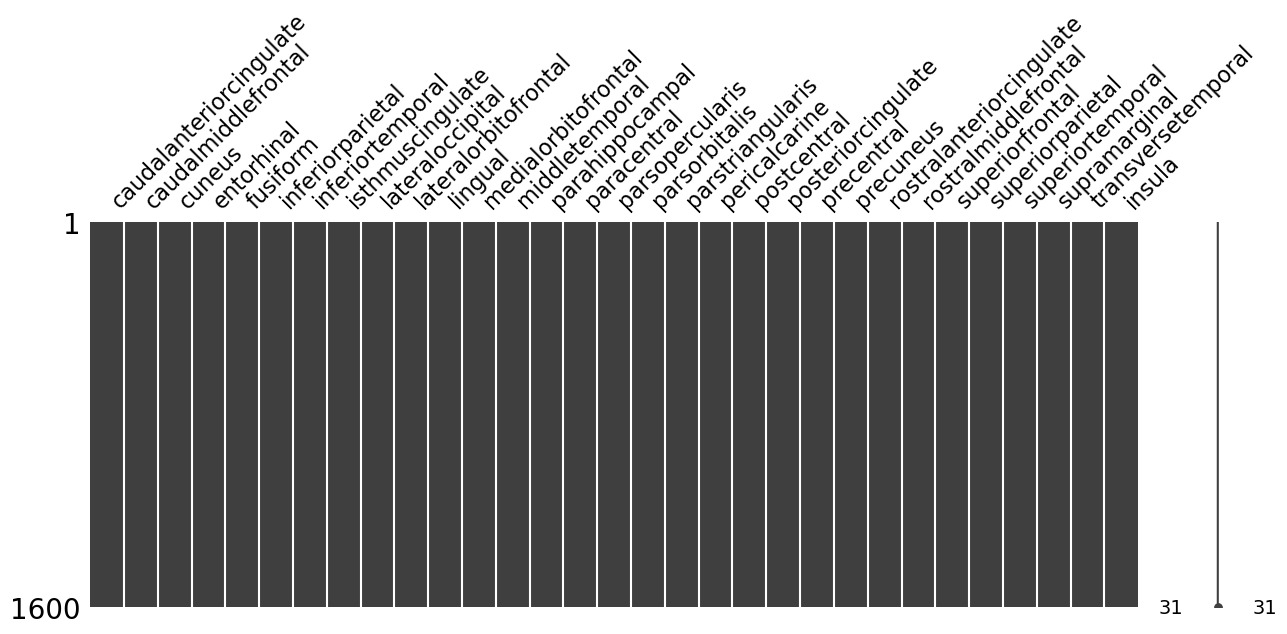

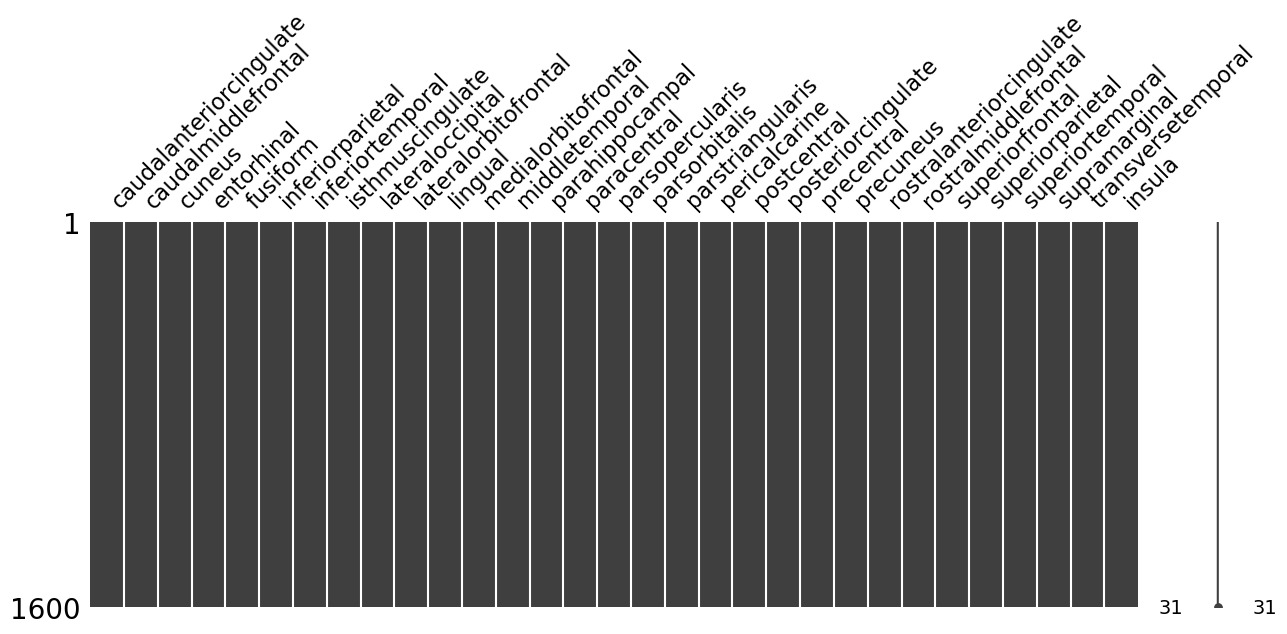

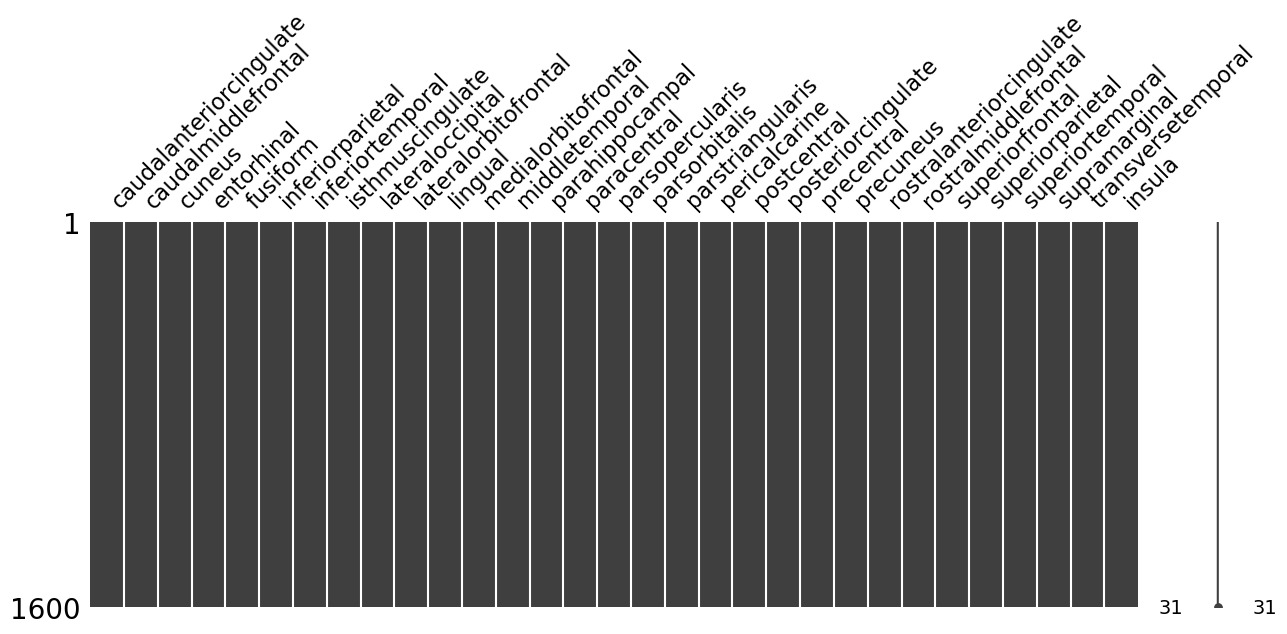

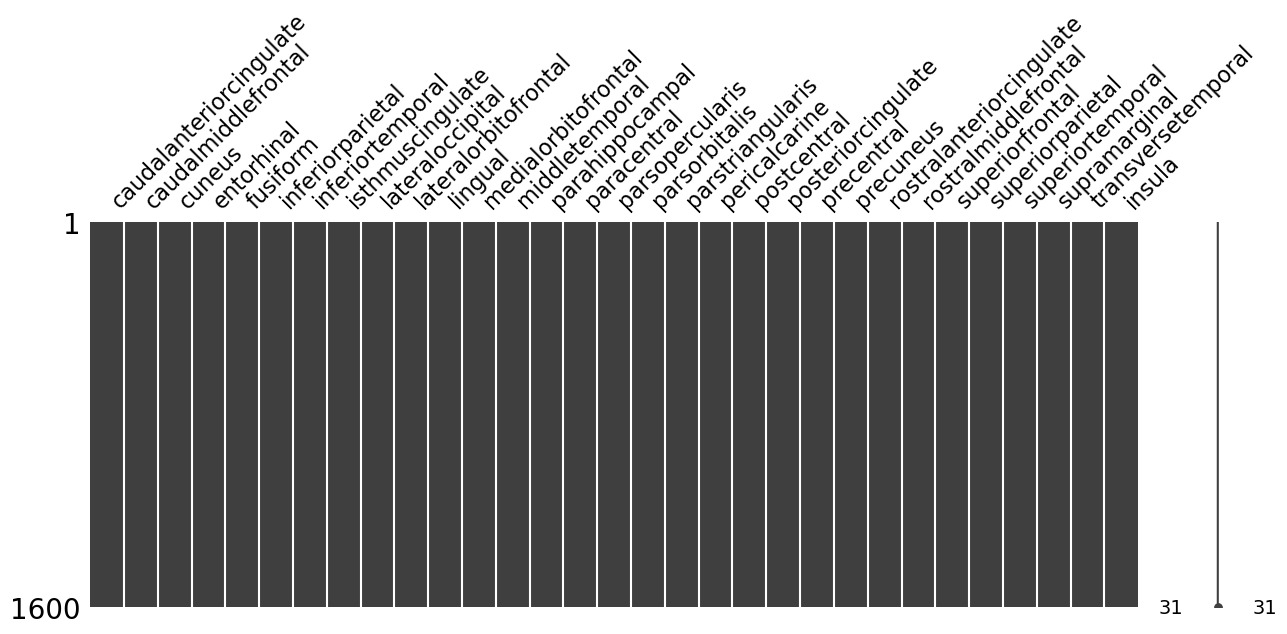

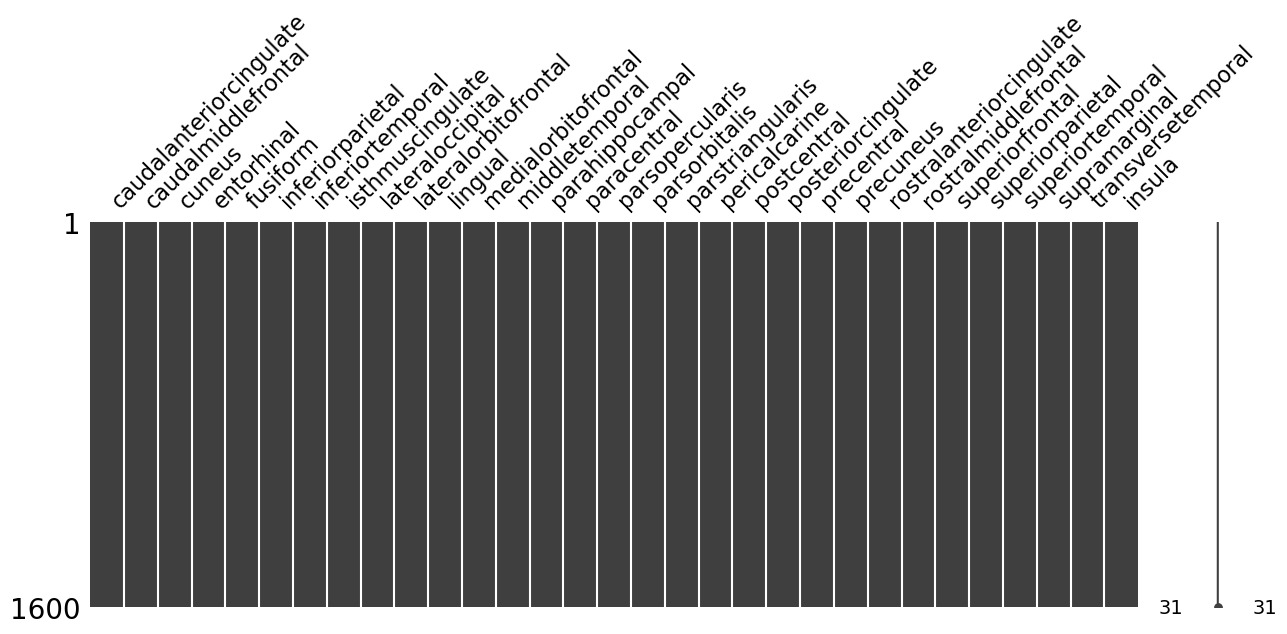

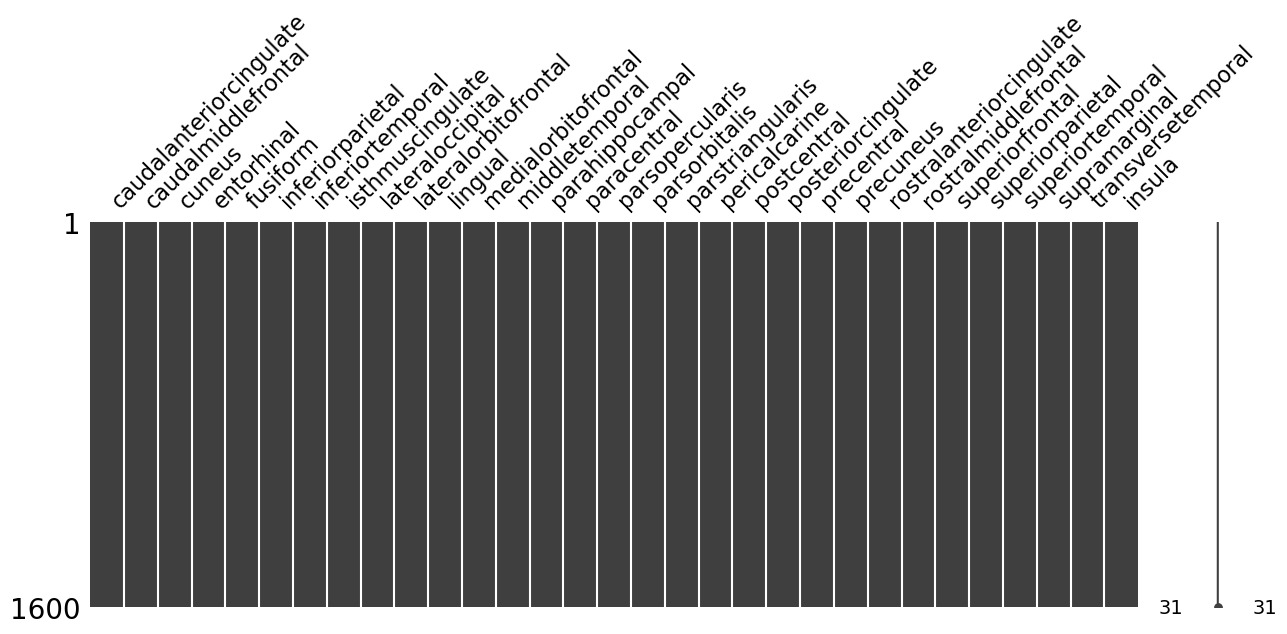

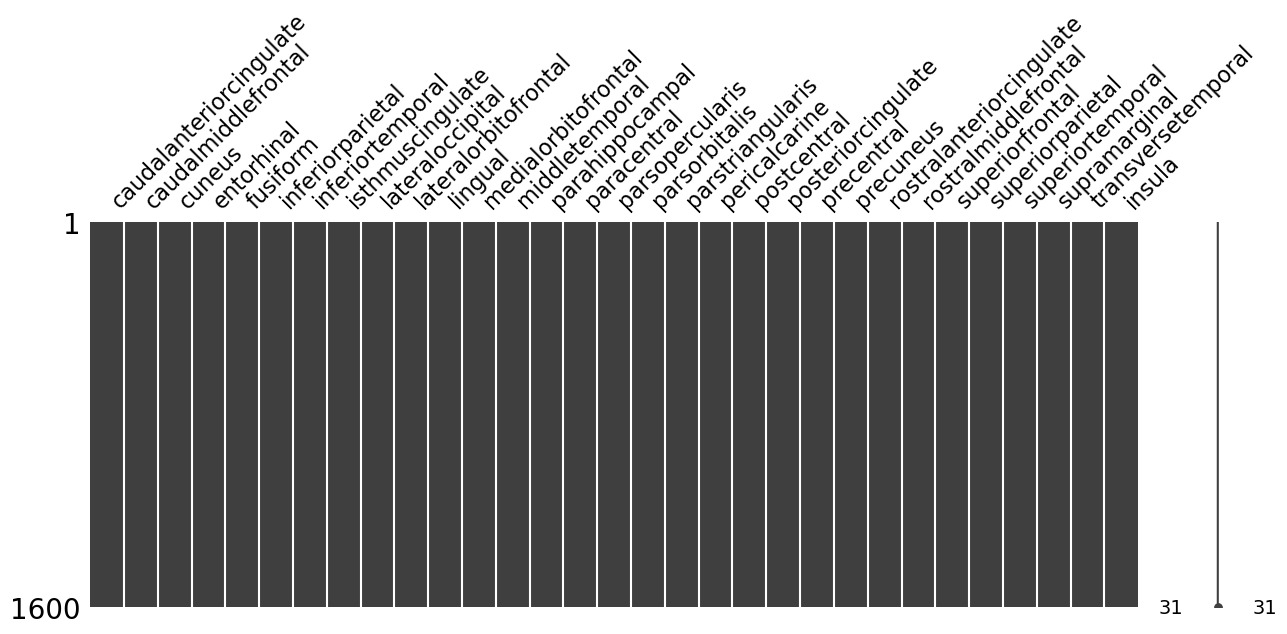

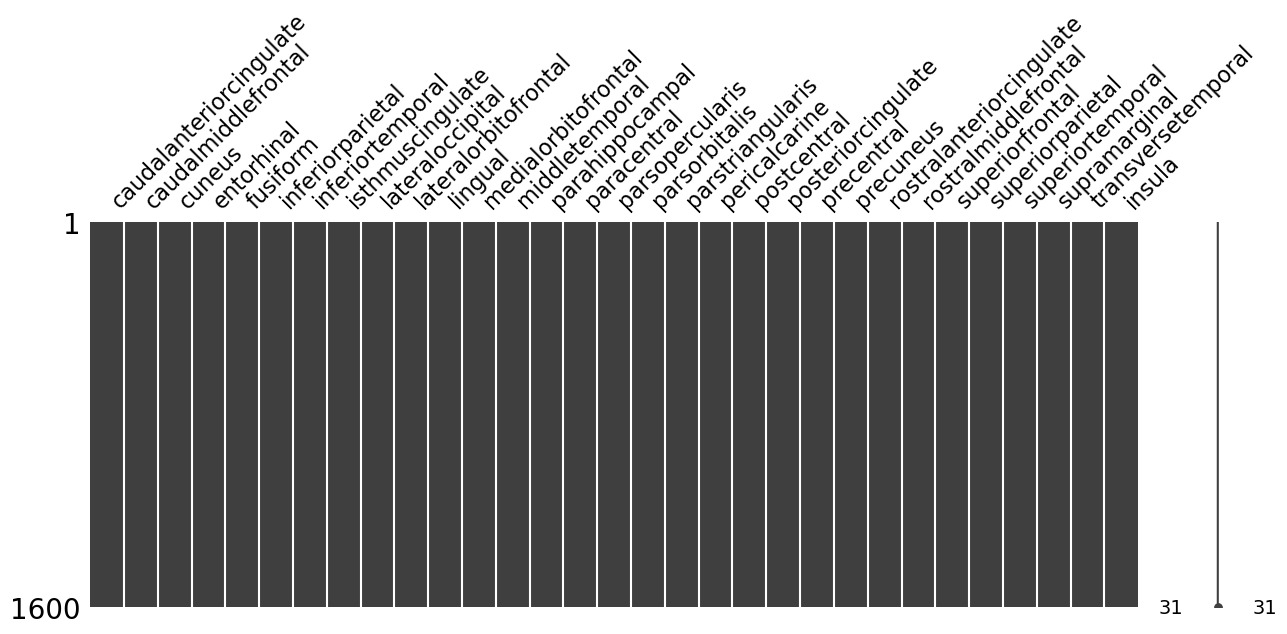

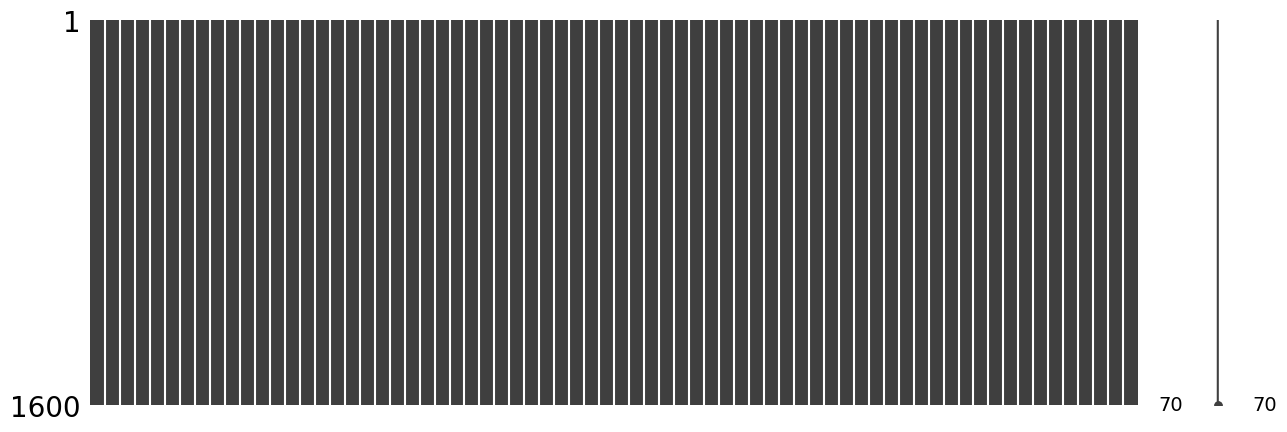

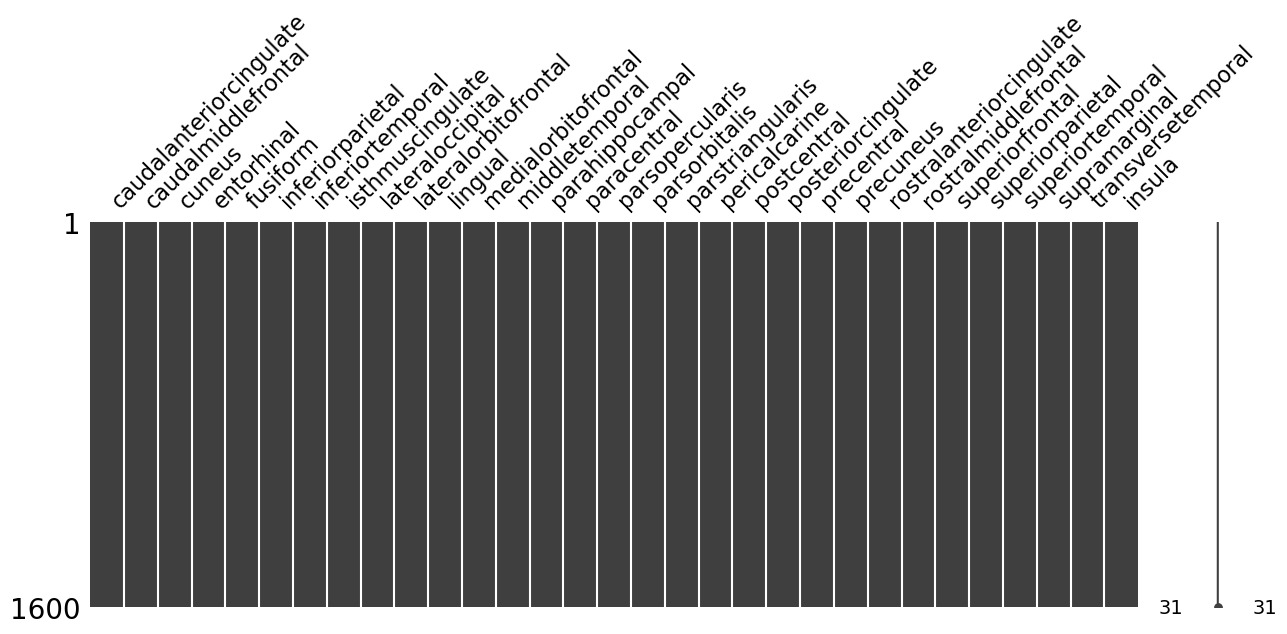

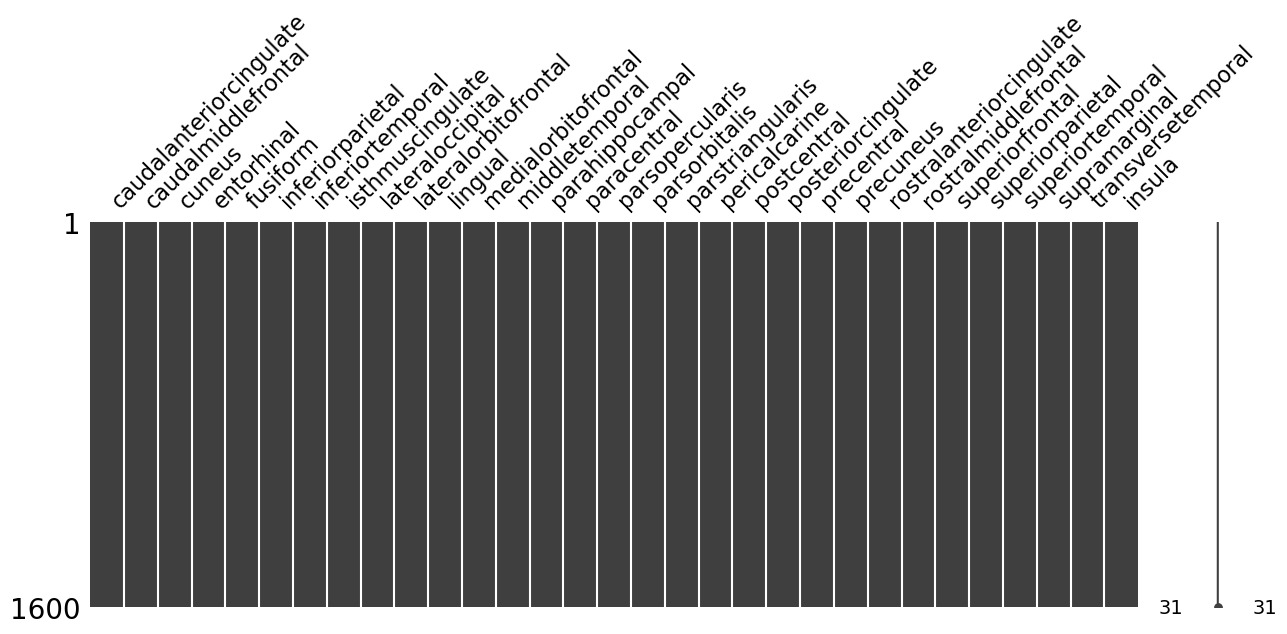

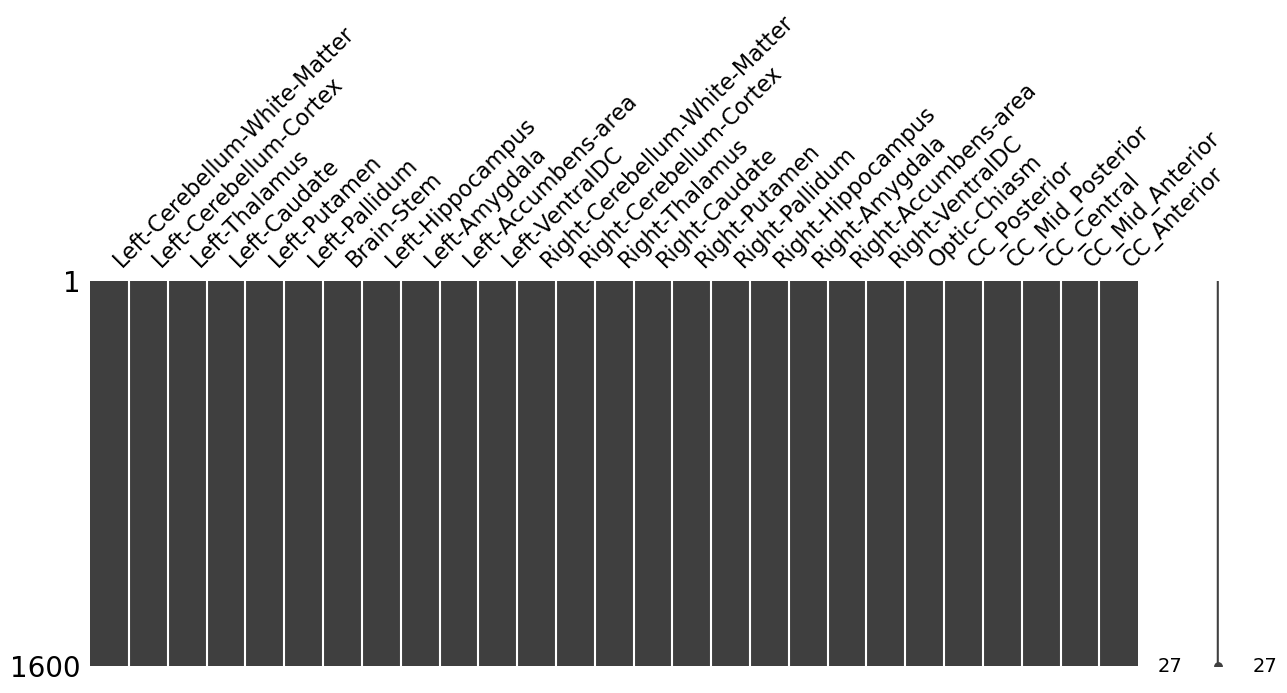

In [44]:
import matplotlib.pyplot as plt

# use missingno to check the dataframe
for index, name in enumerate(train_feature_dict.keys()):
    if name != 'subject_info':
        msno.matrix(train_feature_dict[name], figsize=(15, 5))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# use seaborm to visualize the distribution
for index, name in enumerate(train_feature_dict.keys()):
    if name != 'subject_info':
        sns.distplot(train_feature_dict[name], bins=100, color="green") 
        plt.show()

In [ ]:
def TruncatedPowerBasisFunctionExpanding(X, knots):
    X_dk = X
    k_j = len(knots)
    for h in range(k_j-3):
        X_dk = np.column_stack([X_dk, basis_fuction(X, knots, h) - basis_fuction(X, knots, k_j-2)])
    return X_dk

def basis_fuction(X, knots, h):
    a = np.power(np.abs(X-knots[h]), 3)
    b = np.power(np.abs(X-knots[-1]), 3)
    return ((a - b) / (knots[-1] - knots[h]))

def data_preprocess(data_dict):
    # Min-Max
    new_data_dict = {}
    for index, feature_df in enumerate(data_dict.keys()):
        if 'subject_info' not in feature_df:
            new_data_dict[feature_df] = (data_dict[feature_df] - data_dict[feature_df].min()) / (data_dict[feature_df].max() - data_dict[feature_df].min())
            # new_data_dict[feature_df] = np.array(data_dict[feature_df])
        else:
            new_data_dict[feature_df] = data_dict[feature_df] 
    return new_data_dict

def feature_aug(data_dict):
    new_data_dict = {}
    for index, feature_df in enumerate(data_dict.keys()):
        if 'subject_info' not in feature_df:
            new_data_dict[feature_df] = np.array(data_dict[feature_df], dtype=np.float32)
            new_data_dict[feature_df] = TruncatedPowerBasisFunctionExpanding(data_dict[feature_df], [0, 0.3, 0.6, 0.9, 1])
        else:
            new_data_dict[feature_df] = data_dict[feature_df] 
    return new_data_dict

def feature_combination(data_dict, is_test=False):

    original_x_thick = (data_dict['lh.ThickAvg'] + data_dict['rh.ThickAvg']) * 0.5
    original_x_gauscurv = (data_dict['lh.GausCurv'] + data_dict['rh.GausCurv']) * 0.5
    original_x_meancurv = (data_dict['lh.MeanCurv'] + data_dict['rh.MeanCurv']) * 0.5
    original_x_surfarea = (data_dict['lh.SurfArea'] + data_dict['rh.SurfArea']) * 0.5
    original_x_grayvol = (data_dict['lh.GrayVol'] + data_dict['rh.GrayVol']) * 0.5
    original_x_wmparc = data_dict['wmparc']
    original_x_aseg = data_dict['aseg']

    original_x = np.hstack([
            # original_x_thick, original_x_gauscurv, original_x_meancurv, original_x_surfarea, original_x_grayvol, original_x_wmparc, original_x_aseg, 
            data_dict['lh.ThickAvg'], data_dict['rh.ThickAvg'], data_dict['lh.GausCurv'], data_dict['rh.GausCurv'], data_dict['lh.MeanCurv'],
            data_dict['rh.MeanCurv'], data_dict['lh.SurfArea'], data_dict['rh.SurfArea'], data_dict['lh.GrayVol'], data_dict['rh.GrayVol']
        ])
    
    if not is_test:
        original_y = data_dict['subject_info']
        return original_x, original_y
    else:
        return original_x

# train_x, train_y = feature_combination(data_preprocess(feature_aug(train_feature_dict)))
train_x, train_y = feature_combination(data_preprocess(train_feature_dict))
# test_x = feature_combination(data_preprocess(feature_aug(test_feature_dict)), is_test=True)
test_x = feature_combination(data_preprocess(test_feature_dict), is_test=True)
print(train_x)
print(train_x.shape)
print(test_x.shape)

### ***2 Models***

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from RVM import *

In [ ]:
from sklearn.model_selection import GridSearchCV

# 将数据集分为训练集和测试集
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=0)
X_train = torch.tensor(X_train, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
# y_valid = torch.tensor(y_valid, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)
print(test_x.shape)

# RVR
print('\n RVR Model')

rbf_model = RVR(kernel="rbf")
rbf_model.fit(X_train, y_train)
rbf_model_valid_prediction = rbf_model.predict(X_valid)
print('\nVALID MAE:{}'.format(mean_absolute_error(y_valid, [int(i) for i in rbf_model_valid_prediction])))
print('VALID Variance {}'.format(np.var([int(i) for i in rbf_model_valid_prediction])))
print('LABEL Variance {}'.format(np.var([int(i) for i in y_valid])))
rbf_model_test_prediction = rbf_model.predict(test_x)
print([int(i) for i in rbf_model_test_prediction])
print('TEST Variance {}'.format(np.var([int(i) for i in rbf_model_test_prediction])))

# XGBoost
print('\n XGBoost Model')

xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_model_valid_prediction = xgb_model.predict(X_valid)

print('\nVALID MAE:{}'.format(mean_absolute_error(y_valid, [int(i) for i in xgb_model_valid_prediction])))
print('LABEL Variance {}'.format(np.var([int(i) for i in y_valid])))
print('VALID Variance {}'.format(np.var([int(i) for i in xgb_model_valid_prediction])))
xgb_model_test_prediction = xgb_model.predict(test_x)
print([int(i) for i in xgb_model_test_prediction])
print('TEST Variance {}'.format(np.var([int(i) for i in xgb_model_test_prediction])))

# LightGBM
print('\n LightGBM Model')

lgbm_model = LGBMRegressor()
lgbm_model.fit(X_train, y_train)
lgbm_model_valid_prediction = lgbm_model.predict(X_valid)
print('\nVALID MAE:{}'.format(mean_absolute_error(y_valid, [int(i) for i in lgbm_model_valid_prediction])))
print('LABEL Variance {}'.format(np.var([int(i) for i in y_valid])))
print('VALID Variance {}'.format(np.var([int(i) for i in lgbm_model_valid_prediction])))
lgbm_model_test_prediction = lgbm_model.predict(test_x)
print([int(i) for i in lgbm_model_test_prediction])
print('TEST Variance {}'.format(np.var([int(i) for i in lgbm_model_test_prediction])))

# 集成模型
# print('\n Ensemble Model')

# new_linear_pred, new_rbf_pred, new_poly_pred = [int(i) for i in linear_model_valid_prediction], [int(i) for i in rbf_model_valid_prediction], [int(i) for i in poly_model_valid_prediction]
# new_rf_pred = [int(i) for i in rf_model_valid_prediction]
# new_bag_pred = [int(i) for i in bag_model_valid_prediction]
# new_xgb_pred = [int(i) for i in xgb_model_valid_prediction]
# new_lgbm_pred = [int(i) for i in lgbm_model_valid_prediction]

# # ensemble_prediction = [(i + j) / 2 for i, j in zip(new_rf_pred, new_rbf_pred)]
# ensemble_prediction = [(i + j + k) / 3 for i, j, k in zip(new_xgb_pred, new_bag_pred, new_linear_pred)]
# print('\nENSEMBLE VALID MAE:{}'.format(mean_absolute_error(y_valid, ensemble_prediction)))
# print('ENSEMBLE VALID Variance {}'.format(np.var([int(i) for i in ensemble_prediction])))

# test_new_linear_pred, test_new_rbf_pred, test_new_poly_pred = [int(i) for i in linear_model_test_prediction], [
#     int(i) for i in rbf_model_test_prediction], [int(i) for i in poly_model_test_prediction]
# test_new_bag_pred = [int(i) for i in bag_model_test_prediction]
# test_new_rf_pred = [int(i) for i in rf_model_test_prediction]
# test_new_xgb_pref = [int(i) for i in xgb_model_test_prediction]

# # test_ensemble_prediction = [(i + j) / 2 for i, j in zip(test_new_rf_pred, test_new_rbf_pred)]
# test_ensemble_prediction = [(i + j + k) / 3 for i, j, k in
#                             zip(test_new_xgb_pref, test_new_bag_pred, test_new_linear_pred)]
# print([int(i) for i in test_ensemble_prediction])
# print('TEST Variance {}'.format(np.var([int(i) for i in test_ensemble_prediction])))

# 写结果
# final_list = [int(i) for i in [int(i) for i in lgbm_model_test_prediction]]
# submission_version_name = 'Ensemble-DataAug3-XGBoost_Bagging_RVR'
# write_submission(final_list, submission_version_name)
